<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250730/%E3%82%B0%E3%83%A9%E3%83%95%E5%88%86%E5%89%B2%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
!pip install mip
!pip install japanize-matplotlib

# グラフ分割問題

本講義では、
ネットワーク構造を持つ実世界のシステムにおいて中心的な役割を果たす
「グラフ分割問題 (Graph Partitioning Problem)」について解説します。
グラフ分割問題は、ネットワーク（グラフ）を、互いに枝が密接に接続する部分
（区画、クラスタ、コミュニティなどと呼ぶ）に最適に分割する方法を見つけ出す問題です。
この「最適」とは、多くの場合、異なるクラスタの接続を最小限に抑えつつ、
各クラスタが特定の要件（例えば、サイズが均等であること）を満たすことを
意味します。

この問題は、コンピュータサイエンス、VLSI設計、並列計算、画像処理、社会ネットワーク分析、物流計画など、非常に広範な分野で応用されています。

本講義の目標は以下の通りです。

1.  グラフ分割問題の基本的な概念、その重要性、および多様な応用例を理解する。
2.  グラフ分割問題を数理モデルとして定式化するアプローチ（特に2分割問題）を習得する。
3.  Pythonの最適化ライブラリ `python-mip` を用いて、グラフ分割問題を解くことができるプログラミングスキルを身につける。

## グラフ分割問題の定義

グラフ分割問題とは、与えられたグラフ $G=(V, E)$（$V$は頂点(ノード)の集合、$E$は枝(辺とも呼ばれる、エッジ)の集合、エッジには向きが無い）を、相互に素な（ノードが重なり合わない）複数の部分集合（区画、パーティション）に分割する問題である。
ここでの主な目的は、以下の条件を満たすように分割することである。

1.  **カットサイズの最小化**: 異なる区画に属する頂点間を結ぶ辺の数（または辺の重みの合計）を最小にする。この値を「カットサイズ」と呼ぶ。
2.  **区画サイズの均衡**: 各区画が含む頂点の数（または頂点の重みの合計）を、できるだけ均等にするか、あるいは指定された範囲内に収める。

なお、辺 $(u,v) \in E$ は、頂点 $u$ と頂点 $v$ が異なる区画に割り当てられた場合に「カットされた」と言われる。

### 簡単な例題と図解

簡単なグラフで**2分割**問題を考えてみよう。以下のグラフを、2つの区画の頂点数が
できるだけ等しく（この例では各区画2頂点ずつ）、かつ区画間の辺の数を最小にするように分割する。

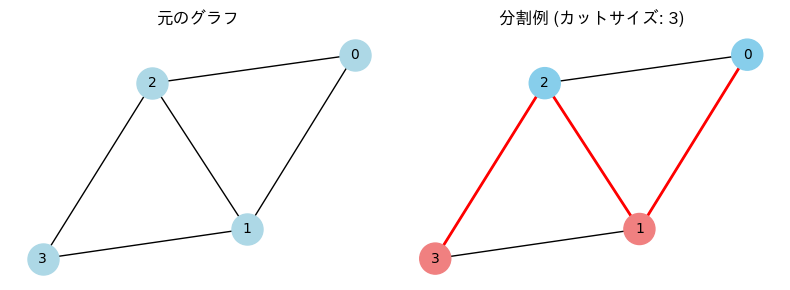

元のグラフの頂点: [0, 1, 2, 3]
元のグラフの辺: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
分割例: 区画0 = [0, 2], 区画1 = [1, 3]
この分割でのカットエッジ: [(0, 1), (1, 2), (2, 3)]


In [ ]:
#@title 図解
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np

# 簡単なグラフの作成
G_example = nx.Graph()
G_example.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)])

# レイアウトの固定
pos_example = nx.spring_layout(G_example, seed=42)

# 分割前のグラフ描画
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
nx.draw(G_example, pos_example, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("元のグラフ")

# 考えられる分割の例 (手動で設定)
# 分割1: {0,2} と {1,3} -> カットエッジ: (0,1), (2,1), (0,3はなし), (2,3) ... カットサイズ 3
# カットエッジ: (0,1), (1,2), (2,3)  (0,2)は区画内, (1,3)は区画内

# 最適な分割の例 (手動): 区画A={0,2}, 区画B={1,3}
# 頂点0 -> 区画A, 頂点1 -> 区画B, 頂点2 -> 区画A, 頂点3 -> 区画B
partition_map_example = {0: 0, 1: 1, 2: 0, 3: 1} # 0:区画A, 1:区画B
colors_example = ['skyblue' if partition_map_example[node] == 0 else 'lightcoral' for node in G_example.nodes()]
cut_edges_example = []
for u, v in G_example.edges():
    if partition_map_example[u] != partition_map_example[v]:
        cut_edges_example.append((u,v))

plt.subplot(1, 2, 2)
nx.draw(G_example, pos_example, with_labels=True, node_color=colors_example, node_size=500, font_size=10)
nx.draw_networkx_edges(G_example, pos_example, edgelist=cut_edges_example, edge_color='red', width=2)
plt.title(f"分割例 (カットサイズ: {len(cut_edges_example)})")
plt.tight_layout()
plt.show()

print(f"元のグラフの頂点: {list(G_example.nodes())}")
print(f"元のグラフの辺: {list(G_example.edges())}")
print(f"分割例: 区画0 = {[n for n, p in partition_map_example.items() if p==0]}, 区画1 = {[n for n, p in partition_map_example.items() if p==1]}")
print(f"この分割でのカットエッジ: {cut_edges_example}")

**図の説明**:
左側は元のグラフである。
このグラフには、4つの頂点と5つの辺がある。すなわち、
頂点（ノード）の集合は
$$
V = \{0,1,2,3\}
$$
であり、辺集合は
$$
E = \{ (0, 1), (0, 2), (1, 2), (1, 3), (2, 3) \}
$$
とする。

右側は、このグラフを2つのノード集合（水色のノード集合と赤色のノード集合）に分割した一例である。
ノード集合間をを結ぶ辺（赤い辺）がカットされた辺であり、
この例では3本ある。
このカットされた辺の数を最小にすることが目標の一つとなる。


## 実社会での応用例

グラフ分割問題は、その汎用性から多岐にわたる分野で応用されている。

  * **VLSI設計 (超大規模集積回路)**:
    回路の構成要素（論理ゲートやモジュール）を頂点、それらの間の接続を辺とするグラフを考える。回路をチップ上の物理的な区画に配置する際、区画間の配線長（カットサイズ）を最小化し、遅延や消費電力を削減する。
  * **並列計算**:
    大規模な計算タスクを複数のプロセッサで並列処理する際、計算の依存関係をグラフで表現する。タスク（頂点）をプロセッサ（区画）に割り当て、プロセッサ間の通信量（カットサイズ）を最小化することで、全体の計算効率を向上させる。
  * **画像セグメンテーション**:
    画像をピクセルのグラフ（隣接ピクセル間に辺）とみなし、類似した特徴を持つピクセル群を同じ領域（区画）にまとめる。区画間の境界の不連続性を評価し、意味のある領域分割を行う。
  * **ソーシャルネットワーク分析**:
    人々を頂点、関係性を辺とするソーシャルグラフにおいて、密接に繋がったコミュニティ（区画）を発見する。区画内の接続は密で、区画間の接続は疎になるような分割を目指す。
  * **物流・配送計画**:
    顧客や地点を頂点、道路網を辺とするグラフで、配送エリア（区画）を効率的に設定し、配送ルートの最適化やリソース配分のバランスを取る。
  * **生物情報学**:
    タンパク質相互作用ネットワークや遺伝子ネットワークにおいて、機能モジュール（区画）を発見する。

これらの応用では、効率的な分割がシステムのパフォーマンスや解析結果の質に大きく影響する。

## 数理モデルによる定式化 (2分割問題の例)

ここでは、指定された区画サイズを満たしつつグラフを2つの区画に分割する「2分割問題」を例に、整数計画問題として定式化する。
目的は、カットサイズを最小化することである。

### 決定変数

  * $x_i$: 頂点 $i \in V$ が区画1に属するならば $1$、区画0に属するならば $0$ をとるバイナリ変数。
  * $z_{uv}$: 辺 $(u,v) \in E$ が2つの異なる区画間を接続しカットとなるならば $1$、そうでない（両端のノードが同じ区画）ならば $0$ となるバイナリ変数。

### パラメータ（定数）

  * $V$: 頂点の集合。$N = |V|$ は総頂点数。
  * $E$: 辺の集合。
  * $w_{uv}$: 辺 $(u,v)$ の重み。重みがない場合は $w_{uv}=1$ とする。
  * $S_0^{target}$, $S_1^{target}$: それぞれ区画0、区画1に割り当てる目標の頂点数。例えば、均等に分けるなら $N/2$ に近い値。
  あるいは、各区画のサイズの下限 $S_k^{min}$ と上限 $S_k^{max}$ を指定する。

### 目的関数

カットサイズ（異なる区画間を結ぶ辺の重みの総和）を最小化する。

$$\min \sum_{(u,v) \in E} w_{uv} z_{uv}$$

### 制約条件

1.  **カット辺の定義**:
    辺 $(u,v)$ がカットとなるのは、頂点 $u$ と頂点 $v$ が異なる区画に属する場合である。
    すなわち、$x\_u \\neq x\_v$ のときに $z\_{uv}=1$ となるようにする。これは以下の線形制約で表現できる。
    $$z_{uv} \ge x_u - x_v \quad \forall (u,v) \in E$$   $$z_{uv} \ge x_v - x_u \quad \forall (u,v) \in E$$
    $x\_u, x\_v$ が共に0または共に1のとき上の式の右辺は0となり、
    $$z\_{uv} \\ge 0$$
    となる。目的が最小化なので $z\_{uv}=0$ となる。 \\
    一方、$x\_u=1, x\_v=0$ のとき、右辺はそれぞれ $1, -1$ となり、
    $$z\_{uv} \\ge 1, z_{uv} \ge -1$$
    となる。目的が最小化なので $z\_{uv}=1$ となり、同様に、$x\_u=0, x\_v=1$ のとき、右辺はそれぞれ $-1, 1$ となり、
    $$z\_{uv} \\ge 1, z_{uv} \ge -1$$
    である。やはり、目的が最小化なので $z\_{uv}=1$ となる。

2.  **区画サイズの制約**:
    * 各区画の頂点数を指定された範囲に収める場合：  
    例えば、区画1のサイズを厳密に $K\_1$ 個にする場合は
    $$\sum_{i \in V} x_i = K_1$$
    となる。
    なお、区画0のサイズは自動的に $N - K\_1$ となる。
    
    * 区画1のサイズを $S\_{1}^{min}$ から $S\_{1}^{max}$ の間とする場合：
    $$S_{1}^{min} \le \sum_{i \in V} x_i \le S_{1}^{max}$$
    区画0のサイズ ($N - \\sum x\_i$) についても同様に制約を設定できる。

3.  **変数型制約**:
$$x_i \in \{0, 1\}, \quad \forall i \in V$$
$$z_{uv} \in \{0, 1\}, \quad \forall (u,v) \in E$$
（実際には、$z_{uv}$ は $0 \le z_{uv} \le 1$ の連続変数としても
目的関数により自動的に0か1の値をとるため、バイナリ変数でなくても良い。）

### 数理モデルのまとめ (2分割)

**目的関数**:
$$\min \sum_{(u,v) \in E} w_{uv} z_{uv}$$

**制約条件**:
$$z_{uv} \ge x_u - x_v \quad \forall (u,v) \in E$$$$z_{uv} \ge x_v - x_u \quad \forall (u,v) \in E$$$$S_{1}^{min} \le \sum_{i \in V} x_i \le S_{1}^{max} \quad (\text{区画1のサイズ制約})$$$$S_{0}^{min} \le \sum_{i \in V} (1-x_i) \le S_{0}^{max} \quad (\text{区画0のサイズ制約})$$$$x_i \in \{0, 1\} \quad \forall i \in V$$
$$z_{uv} \in \{0, 1\} \quad \forall (u,v) \in E$$

この定式化により、グラフ2分割問題を整数計画ソルバーで解くことができる。

## Python MIP を用いた実装 (2分割問題)


In [ ]:
# 必要なライブラリをインポートする
import mip
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np

### グラフの定義と問題設定

例として、Karate Club Graph（データ分析の例題として有名な
社会ネットワークグラフ）を2分割してみよう。

Karate Club Graph（ザカリーの空手クラブ・グラフ）は、
Wayne W. Zacharyによって収集された、
大学の空手クラブにおける34人のメンバー間の社会的関係を表すネットワークデータセットである。
このネットワークは、クラブ内で発生した対立によりクラブが分裂した際のメンバー間の関係を示しており、コミュニティ検出やネットワーク分析の研究で広く利用されている。
なお、このデータは `netowrkx` に含まれており、
以下のコードセルの
```
G = nx.karate_club_graph()
```
の部分で読み込まれる。


なお、
以下の例では、区画のノード数をおよそ半分に設定する。
```
target_size_partition1_min = (num_nodes // 2) - 2 # 少し緩めに設定
target_size_partition1_max = (num_nodes // 2) + 2
```



グラフ: Karate Club Graph
頂点数: 34
辺数: 78
区画1の目標頂点数範囲: [15, 19]


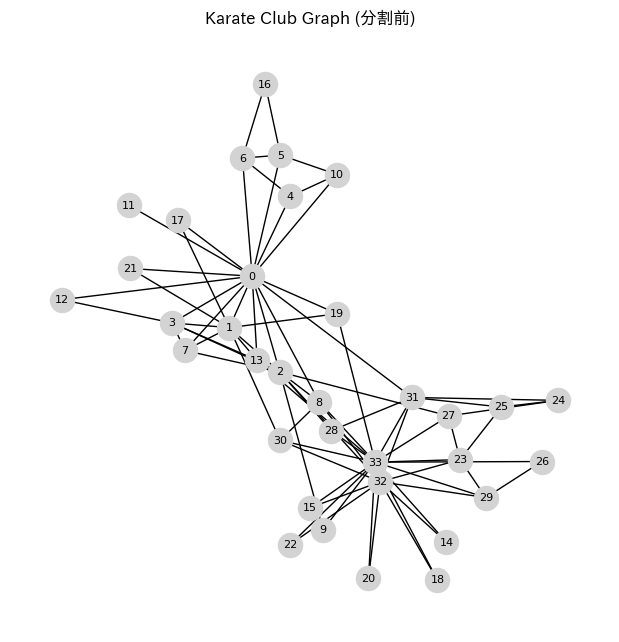

In [ ]:
# グラフの準備 (Karate Club Graph)
G = nx.karate_club_graph()
nodes = list(G.nodes())
edges = list(G.edges())
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"グラフ: Karate Club Graph")
print(f"頂点数: {num_nodes}")
print(f"辺数: {num_edges}")

# 辺の重み (ここでは全て1とする)
edge_weights = {edge: 1 for edge in edges}

# 区画サイズの制約 (できるだけ均等に2分割)
# 例えば、各区画が num_nodes / 2 ± 1 の範囲など
target_size_partition1_min = (num_nodes // 2) - 2 # 少し緩めに設定
target_size_partition1_max = (num_nodes // 2) + 2

print(f"区画1の目標頂点数範囲: [{target_size_partition1_min}, {target_size_partition1_max}]")

# グラフの描画 (初期状態)
plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, seed=42) # レイアウトを固定して後で比較しやすくする
nx.draw(G, pos, with_labels=True, node_color='lightgrey', node_size=300, font_size=8)
plt.title("Karate Club Graph (分割前)")
plt.show()

ノードの集合と枝の集合をリストで定義をしている。

In [ ]:
nodes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

In [ ]:
edges

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 17),
 (0, 19),
 (0, 21),
 (0, 31),
 (1, 2),
 (1, 3),
 (1, 7),
 (1, 13),
 (1, 17),
 (1, 19),
 (1, 21),
 (1, 30),
 (2, 3),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 13),
 (2, 27),
 (2, 28),
 (2, 32),
 (3, 7),
 (3, 12),
 (3, 13),
 (4, 6),
 (4, 10),
 (5, 6),
 (5, 10),
 (5, 16),
 (6, 16),
 (8, 30),
 (8, 32),
 (8, 33),
 (9, 33),
 (13, 33),
 (14, 32),
 (14, 33),
 (15, 32),
 (15, 33),
 (18, 32),
 (18, 33),
 (19, 33),
 (20, 32),
 (20, 33),
 (22, 32),
 (22, 33),
 (23, 25),
 (23, 27),
 (23, 29),
 (23, 32),
 (23, 33),
 (24, 25),
 (24, 27),
 (24, 31),
 (25, 31),
 (26, 29),
 (26, 33),
 (27, 33),
 (28, 31),
 (28, 33),
 (29, 32),
 (29, 33),
 (30, 32),
 (30, 33),
 (31, 32),
 (31, 33),
 (32, 33)]

### モデルの作成と変数の定義

In [ ]:
# 1. モデルの作成
model_gp = mip.Model(name="graph_partition_2way", sense=mip.MINIMIZE, solver_name=mip.CBC)

# 2. 変数の定義
# x_i: 頂点 i が区画1に属するなら1、区画0なら0
x = {i: model_gp.add_var(var_type=mip.BINARY, name=f"x_{i}") for i in nodes}

# z_uv: 辺 (u,v) がカットされるなら1
z = {(u,v): model_gp.add_var(var_type=mip.BINARY, name=f"z_{u}_{v}") for u,v in edges}

### 目的関数の設定

カットサイズを最小化する。

In [ ]:
# 3. 目的関数の設定
model_gp.objective = mip.xsum(edge_weights[edge] * z[edge] for edge in edges)

### 制約条件の追加

In [ ]:
# 4. 制約条件の追加

# カット辺の定義
for u, v in edges:
    model_gp += z[(u,v)] >= x[u] - x[v], f"cut_def1_{u}_{v}"
    model_gp += z[(u,v)] >= x[v] - x[u], f"cut_def2_{u}_{v}"

# 区画サイズの制約
# 区画1のサイズ
model_gp += mip.xsum(x[i] for i in nodes) >= target_size_partition1_min, "p1_size_min"
model_gp += mip.xsum(x[i] for i in nodes) <= target_size_partition1_max, "p1_size_max"

### 問題の求解と結果の表示

In [ ]:
# 5. 問題の求解
print("グラフ分割問題の最適化を開始します...")
# 実行時間に制限を設ける（大規模な問題では時間がかかることがあるため）
status_gp = model_gp.optimize(max_seconds=120) # 例えば2分制限

# 6. 結果の表示
if status_gp == mip.OptimizationStatus.OPTIMAL or status_gp == mip.OptimizationStatus.FEASIBLE:
    if status_gp == mip.OptimizationStatus.OPTIMAL:
        print(f"最適解が見つかりました！")
    else:
        print(f"実行可能解が見つかりました（最適ではない可能性あり）。")

    print(f"最小カットサイズ: {model_gp.objective_value}")

    partition1_nodes = [i for i in nodes if x[i].x >= 0.99]
    partition0_nodes = [i for i in nodes if x[i].x < 0.01] # x[i].x は 0 または 1

    print(f"\n区画1の頂点数: {len(partition1_nodes)} (目標範囲: [{target_size_partition1_min}, {target_size_partition1_max}])")
    print(f"区画1の頂点: {sorted(partition1_nodes)}")
    print(f"区画0の頂点数: {len(partition0_nodes)}")
    print(f"区画0の頂点: {sorted(partition0_nodes)}")
elif status_gp == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件を見直してください。")
elif status_gp == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print("解が見つかりませんでした（時間制限など）。")
else:
    print(f"最適化ステータス: {status_gp}")

グラフ分割問題の最適化を開始します...
最適解が見つかりました！
最小カットサイズ: 10.0

区画1の頂点数: 15 (目標範囲: [15, 19])
区画1の頂点: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
区画0の頂点数: 19
区画0の頂点: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


###結果の可視化

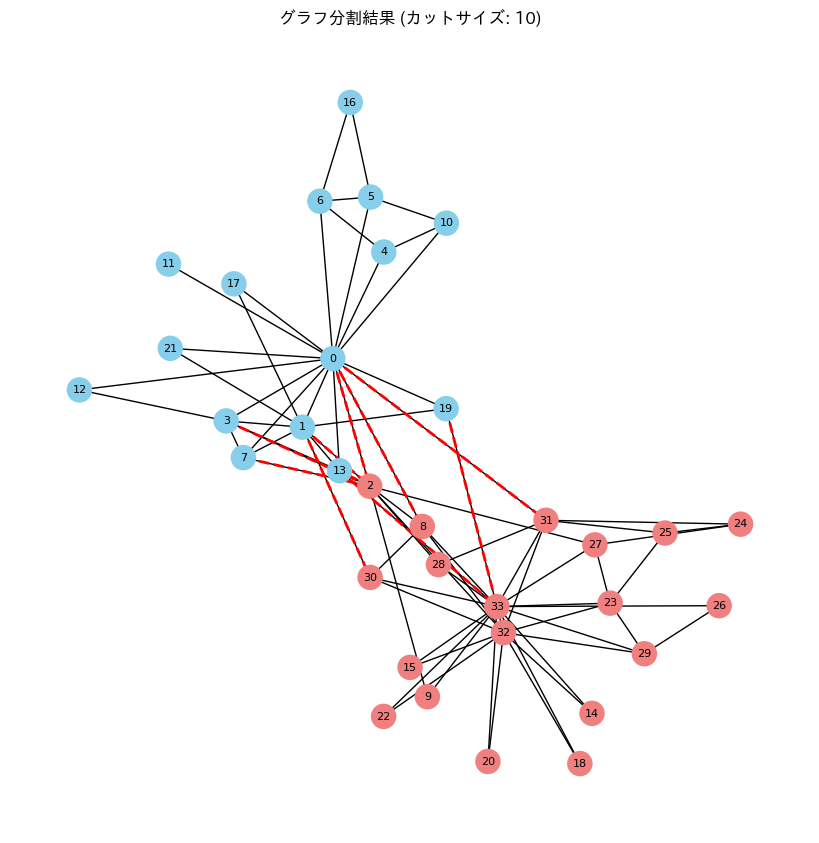

In [ ]:
# 7. 結果の可視化
if status_gp == mip.OptimizationStatus.OPTIMAL or status_gp == mip.OptimizationStatus.FEASIBLE:
    node_colors = []
    for node in G.nodes():
        if node in partition1_nodes:
            node_colors.append('skyblue') # 区画1の色
        else:
            node_colors.append('lightcoral') # 区画0の色

    cut_edge_list = []
    for u,v in edges:
        if z[(u,v)].x >= 0.99 :
             cut_edge_list.append((u,v))

    plt.figure(figsize=(8,8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, font_size=8)
    nx.draw_networkx_edges(G, pos, edgelist=cut_edge_list, edge_color='red', width=2, style='dashed')
    plt.title(f"グラフ分割結果 (カットサイズ: {model_gp.objective_value:.0f})")
    plt.show()

elif status_gp == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 解が存在しません。制約条件を見直してください。")
elif status_gp == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print("解が見つかりませんでした（時間制限など）。")
else:
    print(f"最適化ステータス: {status_gp}")

### モデルの拡張と課題

  * **マルチウェイ分割（k分割）**:
  グラフを3つ以上の区画に分割する場合、定式化がより複雑になる。
  一般的なアプローチの一つは、各頂点 $i$ がどの区画
  $p \in \{1, \dots, k\}$ に属するかを示すバイナリ変数 $x_{ip}$ を導入する。

   * 各頂点 $i \in V$ はちょうど1つの区画に属す:
$$\sum_{p=1}^k x_{ip} = 1 \quad \forall i \in V$$
   * 辺 $(u,v)$ がカットされるのは、頂点 $u$ と頂点 $v$ が異なる区画に属する場合。これを判定する変数 $y_{uv}$ を導入し、目的関数
$$\min \sum w_{uv}y_{uv}$$
とする。また、制約条件に以下を設定する。
$$y_{uv} \ge x_{up} - x_{vp}, \quad \forall (u,v) \in E, \forall p \in {1, \dots, k}$$
$$y_{uv} \ge x_{vp} - x_{up}, \quad \forall (u,v) \in E, \forall p \in {1, \dots, k}$$
この制約は、頂点 $u$ が区画 $p$ にあり、頂点 $v$ が区画 $p$ にない場合（またはその逆）に $y_{uv}=1$ とすることを強制する。

   * 各区画 $p$ のサイズ制約:
$$ S_{p}^{min} \le \sum_{i \in V} x_{ip} \le S_{p}^{max}$$

  * **NP困難性**:
    グラフ分割問題（特に辺のカットを最小化しつつ区画サイズのバランスを取るもの）は、一般的にNP困難であることが知られている。これは、グラフのサイズが大きくなると、厳密な最適解を現実的な時間で見つけることが非常に難しくなることを意味する。MIPソルバーも、大規模なインスタンスでは苦戦することがある。

  * **ヒューリスティック解法**:
    NP困難性のため、実用上は近似解を高速に得るためのヒューリスティックアルゴリズムやメタヒューリスティクスも広く用いられる。本講義ではMIPを用いた厳密解法に焦点を当てているが、これらの近似解法の存在も理解しておくことが重要である。

#演習問題

##**演習問題 1:**

以下のグラフを、各区画の頂点数が2または3となるように二分割し、
カットサイズを最小化せよ。辺の重みは全て1とする。

  * 頂点: $0, 1, 2, 3, 4, 5$
  * 辺: $(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (2,5),(3,5),(4,5)$

##**演習問題 2:**

演習問題1のグラフを区画の頂点数が3となるように二分割し、
最小カットサイズを解答せよ。

##**演習問題 3:**

辺に重みのある以下のグラフで、頂点数6を均等に（各区画3頂点）
二分割し、カットされる辺の重みの合計を最小化せよ。

  * 頂点: $0, 1, 2, 3, 4, 5$
  * 辺と重み:
      * $(0,1, w=3), (0,2, w=1), (0,3, w=2)$
      * $(1,2, w=2), (1,4, w=4)$
      * $(2,3, w=5), (2,4, w=1), (2,5, w=2)$
      * $(3,5, w=3)$
      * $(4,5, w=2)$

##**演習問題 4:**

演習問題1のグラフと条件で、頂点2と頂点4が必ず異なる区画に属するように制約を加えて二分割し、カットサイズを最小化せよ。


##**演習問題 5:**

演習問題1のグラフ（頂点数6）を、3つの区画に分割することを考える。3つの区画にそれぞれ2頂点ずつ均等に分割する。
異なる区画間のカットサイズを最小化し、カットサイズを解答せよ。

##**演習問題 6:**

演習問題3のグラフと条件（各区画3頂点）で、頂点0, 頂点1, 頂点2 が必ず同じ区画に属するように制約を加えて2分割し、カットサイズを最小化せよ。
